In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_adata = ad.read_h5ad("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/Colab Notebooks-Joshua/data/Biddy_train.h5ad")
test_adata = ad.read_h5ad("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/Colab Notebooks-Joshua/data/Biddy_test.h5ad")

In [3]:
train_adata

AnnData object with n_obs × n_vars = 5893 × 2000
    obs: 'timecourse', 'reprogramming_day', 'reprogramming', 'cell_type', 'cell_cycle', 'cluster', 'monocle_state', 'pseudotime', 'CellTagD0_85k', 'CellTagD3_85k', 'CellTagD13_85k', 'CellTagD0_48k', 'CellTagD3_48k', 'CellTagD13_48k', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_cycle_colors', 'cluster_colors', 'hvg', 'log1p', 'reprogramming_colors', 'reprogramming_day_colors'
    obsm: 'X_diff', 'X_tsne'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [4]:
train_adata.obs['cell_type']

HF1_CGAGAAGAGATGTTAG_6    Fibroblast
HF1_TTGGCAACATTATCTC_8           iEP
HF1_CTTTGCGTCTTGAGGT_8     Ambiguous
HF1_CACAGGCTCCAAACAC_8           iEP
HF1_TAGTGGTAGCTCTCGG_7           iEP
                             ...    
HF2_CCTAGCTGTGCGGTAA_4           iEP
HF2_TACTTACCAAGCCCAC_4    Fibroblast
HF2_TCCACACGTGAGGGAG_4           iEP
HF2_TTAACTCCACGTCAGC_4    Fibroblast
HF2_TTCCCAGGTGATGATA_4           iEP
Name: cell_type, Length: 5893, dtype: category
Categories (3, object): ['Ambiguous', 'Fibroblast', 'iEP']

In [5]:
test_adata

AnnData object with n_obs × n_vars = 641 × 2000
    obs: 'timecourse', 'reprogramming_day', 'reprogramming', 'cell_type', 'cell_cycle', 'cluster', 'monocle_state', 'pseudotime', 'CellTagD0_85k', 'CellTagD3_85k', 'CellTagD13_85k', 'CellTagD0_48k', 'CellTagD3_48k', 'CellTagD13_48k', 'clone_id', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_cycle_colors', 'cluster_colors', 'hvg', 'log1p', 'reprogramming_colors', 'reprogramming_day_colors'
    obsm: 'X_diff', 'X_tsne'
    layers: 'raw_counts', 'spliced', 'unspliced'

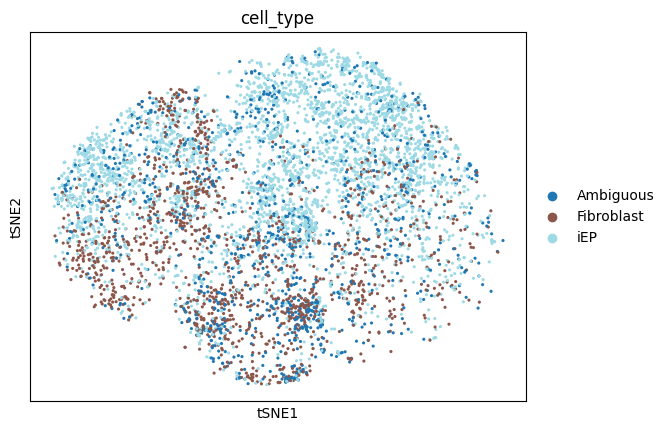

In [6]:
# Ensure seurat_clusters is categorical
train_adata.obs['cell_type'] = train_adata.obs['cell_type'].astype('category')

# Plot UMAP colored by seurat_clusters
sc.pl.tsne(train_adata, color='cell_type', palette='tab20')


In [7]:
# Load the embedding
new_embedding = np.load("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/Colab Notebooks-Joshua/output/LCL_2025/Cell_tag/feat_celltag_lambda1_unlab5_bs50/scBaseEncoderFeat_Z_bs50_tau0.5.npy")

# Check shape: should be (n_cells, n_features) and match adata.n_obs
print(new_embedding.shape, train_adata.n_obs)

# Attach as new obsm entry
train_adata.obsm["X_LCL"] = new_embedding

(5893, 64) 5893


In [8]:
original_umap_layout = train_adata.obsm['X_tsne'].copy()

# Step 1: Compute neighbors using the custom embedding
sc.pp.neighbors(train_adata, use_rep='X_LCL')

# Step 2: Compute UMAP
sc.tl.umap(train_adata)

# 3. Save the UMAP layout under a new key
train_adata.obsm["X_umap_LCL"] = train_adata.obsm["X_umap"].copy()

# 4. (Optional) Restore the original UMAP if needed
train_adata.obsm["X_tsne"] = original_umap_layout

/opt/miniconda3/envs/scVI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


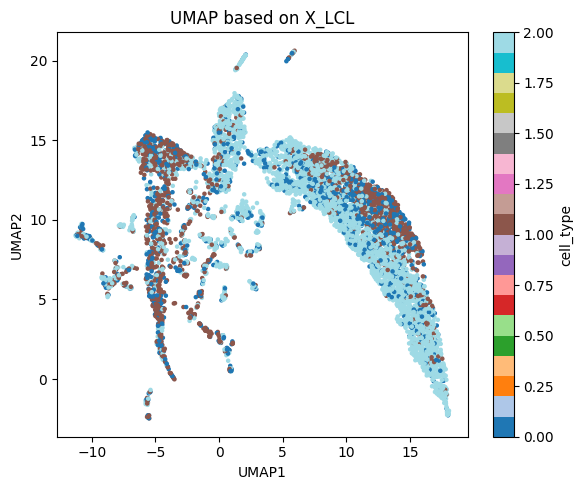

In [9]:
umap_coords = train_adata.obsm["X_umap_LCL"]
cluster_labels = train_adata.obs["cell_type"].astype("category").cat.codes

plt.figure(figsize=(6, 5))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_labels, cmap='tab20', s=5)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP based on X_LCL")
plt.colorbar(label="cell_type")
plt.tight_layout()
plt.show()


In [ ]:
df = pd.DataFrame(train_adata.obsm["X_LCL"], index=train_adata.obs_names)
df.to_csv("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup9b/train_adata_LCL_other-lcl.csv")

In [11]:
# Load the embedding
new_embedding = np.load("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/Colab Notebooks-Joshua/output/LCL_2025/Cell_tag/feat_celltag_lambda1_unlab5_bs50/test_embedding.npy")

# Check shape: should be (n_cells, n_features) and match adata.n_obs
print(new_embedding.shape, test_adata.n_obs)

# Attach as new obsm entry
test_adata.obsm["X_LCL"] = new_embedding

(641, 64) 641


In [12]:
df = pd.DataFrame(test_adata.obsm["X_LCL"], index=test_adata.obs_names)
df.to_csv("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup9b/test_adata_LCL_other-lcl.csv")